# Hate Speech Detection using Naive Bayes and KNN

Objectives : Testing if identically Named ML Techniques yield same results.

Datasets used : - Twitter hate speech datasets of the following projects - 
<br>
1. Ethos Dataset - https://raw.githubusercontent.com/intelligence-csd-auth-gr/Ethos-Hate-Speech-Dataset/master/ethos/hs_data/en_dataset_with_stop_words.csv
<br><br>
2. Dynamically generated Twitter Dataset - https://raw.githubusercontent.com/bvidgen/Dynamically-Generated-Hate-Speech-Dataset/main/Dynamically%20Generated%20Hate%20Dataset%20v0.2.2.csv
<br><br>
3. Multilingual Hate speech - https://raw.githubusercontent.com/vidhur2k/Multilngual-Hate-Speech/main/data/raw/english-basile/hateval2019_en_dev.csv


# Requirements for the project - 


**<i>Inorder to reproduce the result, Please make sure you are running the below line in your command promt to create the environment</i>**
<br>
pip install -r requirement.txt


In [32]:
import pandas as pd
import re
from pprint import pprint
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rizwana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rizwana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Rizwana\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Rizwana\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Preprocessing of the datasets

Process - 

1. Textual processing :<br>
    i. Remove URLs<br>
    ii. Remove hashtags<br>
    iii. Remove mentions<br>
    iv. Remove punctuation and converts to lowercase<br>
    v. Remove numbers<br>
    vi. Remove extra whitespace<br>
    vii. Tokenize the text<br>
    viii. Remove stop words<br>
    ix. Stem tokens<br>
<br>
2. Retaining necessary columns and renaming columns to maintain uniformity of the data.
<br><br>
3. Fetching all the words and counts related to hate speech.

Before oversampling - 
Dataset 1 with 5647 rows:
1    4986
0     661
Name: marker, dtype: int64


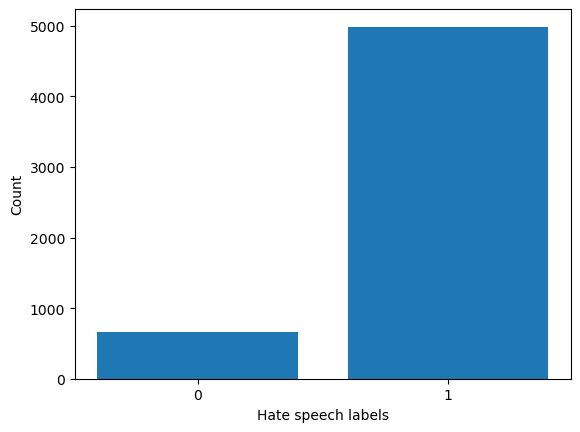


Dataset 2 with 5000 rows:
1    2608
0    2392
Name: marker, dtype: int64


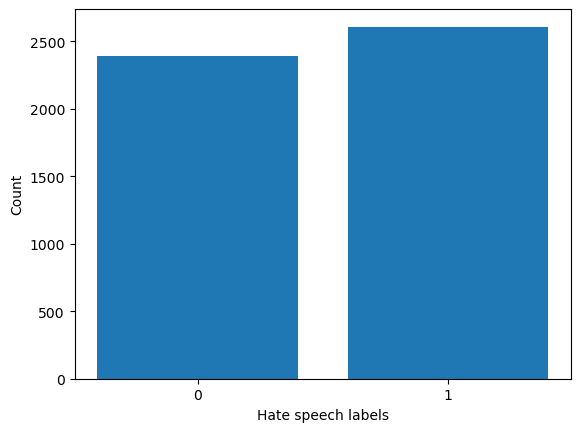


Dataset 3 with 1000 rows:
0    573
1    427
Name: marker, dtype: int64


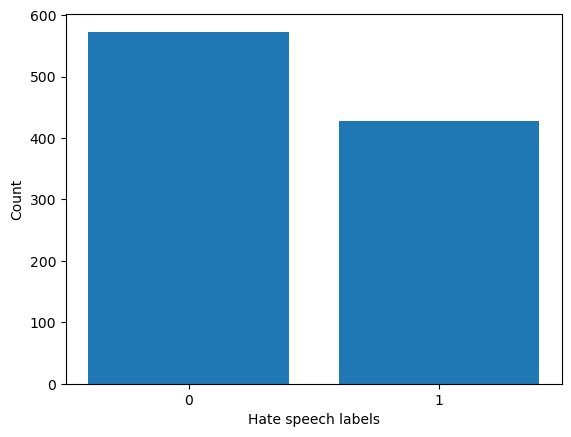

In [34]:
df1 = pd.read_csv("https://raw.githubusercontent.com/intelligence-csd-auth-gr/Ethos-Hate-Speech-Dataset/master/ethos/hs_data/en_dataset_with_stop_words.csv")
df2 = pd.read_csv("https://raw.githubusercontent.com/bvidgen/Dynamically-Generated-Hate-Speech-Dataset/main/Dynamically%20Generated%20Hate%20Dataset%20v0.2.2.csv")
df2 = df2.iloc[:5000,:]
df3 = pd.read_csv("https://raw.githubusercontent.com/vidhur2k/Multilngual-Hate-Speech/main/data/raw/english-basile/hateval2019_en_dev.csv")



def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_tweet(text):
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    # remove hashtags
    text = re.sub(r'#\S+', '', text)
    # remove mentions
    text = re.sub(r'@\S+', '', text)
    # remove punctuation and convert to lowercase
    text = re.sub(r'[^\w\s]', '', text).lower()
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # tokenize text
    tokens = word_tokenize(text)

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if not word in stop_words]

    # stem tokens
    stemmer = SnowballStemmer("english")
    tokens = [stemmer.stem(word) for word in tokens]
    
    pos_tags = nltk.pos_tag(tokens)
    # Lemmatize each token with its corresponding WordNet tag
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag)) for word, pos_tag in pos_tags]

    # join tokens back into a single string
    text = " ".join(lemmatized_tokens)
    
    return text

def preprocessing_dataset(df1, df2, df3):
    #preprocessing df1 - ethos dataset
    df1 = df1.drop(['HITId','directness', 'annotator_sentiment', 'target', 'group'], axis=1)
    df1.sentiment = df1.sentiment.astype('category')
    df1['marker'] = 1
    df1.loc[df1['sentiment'] == 'normal', 'marker'] = 0
    df1.rename(columns = {'sentiment':'label'}, inplace = True)
    df1['tweet'] = df1['tweet'].apply(clean_tweet)
    
    #preprocessing df2
    df2 = df2.drop(["Unnamed: 0","acl.id","X1","type","target","level","split","round.base","annotator","round","acl.id.matched"], axis=1)
    df2.rename(columns = {'text':'tweet'}, inplace = True)
    df2['marker'] = 1
    df2.loc[df2['label'] == 'nothate', 'marker'] = 0
    
    df2['tweet'] = df2['tweet'].apply(clean_tweet)
    
    #preprocessing df3
    df3 = df3.drop(['id','TR','AG'], axis=1)
    df3.rename(columns = {'text':'tweet'}, inplace = True)
    df3.rename(columns = {'HS':'marker'}, inplace = True)
    df3['tweet'] = df3['tweet'].apply(clean_tweet)
    
    return df1, df2, df3
    
df1, df2, df3 = preprocessing_dataset(df1, df2, df3)

import matplotlib.pyplot as plt

def plot_hist(df):
    # Plot the histogram
    plt.hist(df['marker'], bins=[-0.5, 0.5, 1.5], align='mid', rwidth=0.8)

    # Set the x-axis and y-axis labels
    plt.xlabel('Hate speech labels')
    plt.ylabel('Count')

    # Set the x-axis tick labels
    plt.xticks([0, 1], ['0', '1'])

    # Show the plot
    plt.show()

print("Before oversampling - ")

print("Dataset 1 with {} rows:".format(df1.shape[0]))
print(df1['marker'].value_counts())
plot_hist(df1)

print("\nDataset 2 with {} rows:".format(df2.shape[0]))
print(df2['marker'].value_counts())
plot_hist(df2)

print("\nDataset 3 with {} rows:".format(df3.shape[0]))
print(df3['marker'].value_counts())
plot_hist(df3)


After oversampling - 
Dataset 1 with 5000 rows:
0    2567
1    2433
Name: marker, dtype: int64


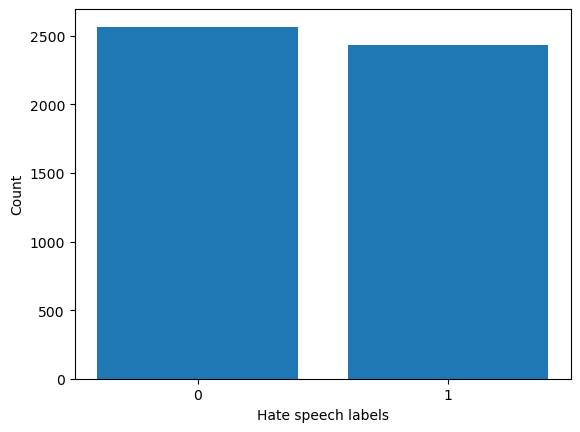


Dataset 2 with 5216 rows:
0    2608
1    2608
Name: marker, dtype: int64


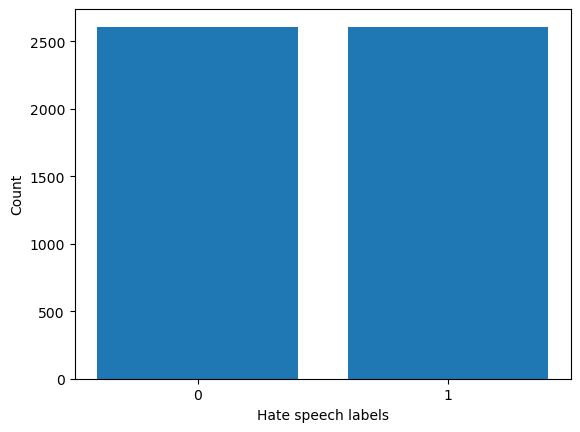


Dataset 3 with 1146 rows:
1    573
0    573
Name: marker, dtype: int64


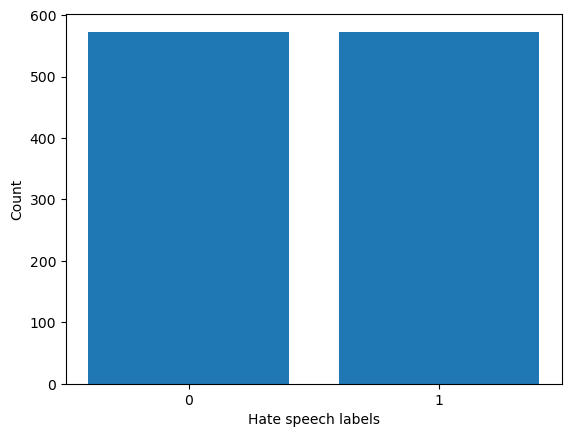

In [35]:
def oversampling_df(df, minn, maxx):
    minority_df = df[df['marker'] == minn]
    majority_df = df[df['marker'] == maxx]

    # Determine the number of samples in each class
    n_minority = len(minority_df)
    n_majority = len(majority_df)

    # Randomly duplicate some samples from the minority class
    oversampled_minority_df = minority_df.sample(n=n_majority, replace=True, random_state=42)

    # Combine the oversampled minority class with the majority class
    oversampled_df = pd.concat([oversampled_minority_df, majority_df])

    # Shuffle the combined dataframe to randomize the order of samples
    oversampled_df = oversampled_df.sample(frac=1, random_state=42)
    return oversampled_df

df1 = oversampling_df(df1, 0, 1)
df1 = df1.iloc[:5000,:]
df2 = oversampling_df(df2, 0, 1)
df3 = oversampling_df(df3, 1, 0)

print("After oversampling - ")

print("Dataset 1 with {} rows:".format(df1.shape[0]))
print(df1['marker'].value_counts())
plot_hist(df1)

print("\nDataset 2 with {} rows:".format(df2.shape[0]))
print(df2['marker'].value_counts())
plot_hist(df2)

print("\nDataset 3 with {} rows:".format(df3.shape[0]))
print(df3['marker'].value_counts())
plot_hist(df3)

df1.to_csv('file1.csv')
df2.to_csv('file2.csv')
df3.to_csv('file3.csv')

#all_data.to_csv("final_combined_preprocessed.csv", index=False)


# Word frequency for the tweets -

In [36]:
import re
import spacy
nlp = spacy.load('fr_core_news_sm')
from collections import Counter
nlp.max_length = 2000000 #or any large value, as long as you don't run out of RAM

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def slice_dataframe_and_compute_word_frequency(df, slice_cols, slice_vals, text_col, spacy_lang_pkg):
    sliced_df = df.copy()
    for i in range(len(slice_cols)):
        sliced_df = sliced_df[sliced_df[slice_cols[i]] == slice_vals[i]]
    print(f'Found a total of {len(sliced_df)} examples')
    nlp = spacy.load(spacy_lang_pkg)
    text = ' '.join(sliced_df[text_col])
    text = remove_emoji(text)
    doc = nlp(text)
    words = [token.text for token in doc if not token.is_stop and not token.is_punct and len(token) > 1]
    freqs = Counter(words)
    pos_counts = doc.count_by(spacy.attrs.POS)
    total = 0
    for k,v in sorted(pos_counts.items()):
        total += v
        print(f'{k:{4}}. {doc.vocab[k].text:{5}}: {v}')
    print('total', total)
    return freqs

print("\nDataset - 1 : Hate words frequency")
freqs1 = slice_dataframe_and_compute_word_frequency(df1, ['marker'], [0], 'tweet', 'fr_core_news_sm')
freqs1 = freqs1.most_common()[:10]
print("\nDataset 1 : Top 10 most common words:")
print(f"{'Word':{15}} {'Frequency':{15}}")
for word, freq in freqs1:
    print(f"{word:{15}} {freq:{10}}")
    

print("\nDataset - 2 : Hate words frequency")
freqs2 = slice_dataframe_and_compute_word_frequency(df2, ['marker'], [0], 'tweet', 'fr_core_news_sm')
freqs2 = freqs2.most_common()[:10]
print("\nDataset 2 : Top 10 most common words:")
print(f"{'Word':{15}} {'Frequency':{15}}")
for word, freq in freqs2:
    print(f"{word:{15}} {freq:{10}}")
    

print("\nDataset - 3 : Hate words frequency")
freqs3 = slice_dataframe_and_compute_word_frequency(df3, ['marker'], [0], 'tweet', 'fr_core_news_sm')
freqs3 = freqs3.most_common()[:10]
print("\nDataset 3 : Top 10 most common words:")
print(f"{'Word':{15}} {'Frequency':{15}}")
for word, freq in freqs3:
    print(f"{word:{15}} {freq:{10}}")


Dataset - 1 : Hate words frequency
Found a total of 2567 examples
  84. ADJ  : 6518
  85. ADP  : 755
  86. ADV  : 967
  87. AUX  : 409
  89. CCONJ: 244
  90. DET  : 698
  92. NOUN : 4801
  93. NUM  : 153
  95. PRON : 576
  96. PROPN: 1187
  97. PUNCT: 20
  98. SCONJ: 24
  99. SYM  : 1
 100. VERB : 3901
 101. X    : 445
 103. SPACE: 23
total 20722

Dataset 1 : Top 10 most common words:
Word            Frequency      
retard                 432
like                   230
countri                227
call                   221
get                    211
shithol                195
faggot                 190
twat                   176
spic                   171
fuck                   170

Dataset - 2 : Hate words frequency
Found a total of 2608 examples
  84. ADJ  : 5299
  85. ADP  : 397
  86. ADV  : 815
  87. AUX  : 326
  89. CCONJ: 131
  90. DET  : 374
  92. NOUN : 4062
  93. NUM  : 123
  95. PRON : 401
  96. PROPN: 1045
  97. PUNCT: 7
  98. SCONJ: 9
 100. VERB : 3426
 101. X    : 498
tota

# Word clouds for the tweets from Datasets -

Dataset 1: Word cloud


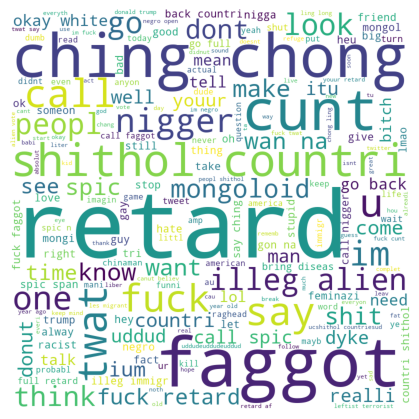


Dataset 2: Word cloud


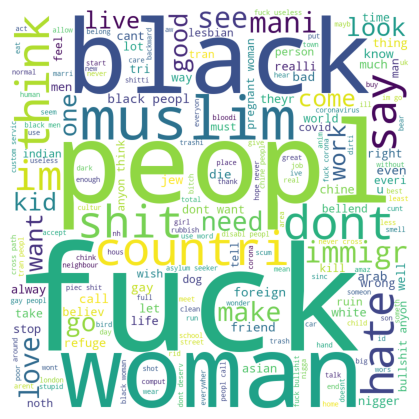


Dataset 3: Word cloud


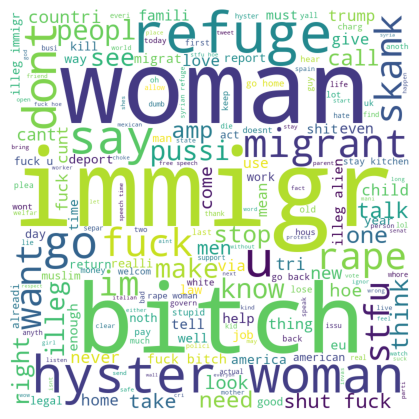

In [37]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def word_cloud(df):
    
    comment_words = ''
    stopwords = set(STOPWORDS)

    # iterate through the csv file
    for val in df.tweet:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

    # plot the WordCloud image                      
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

print("Dataset 1: Word cloud")
word_cloud(df1)
print("\nDataset 2: Word cloud")
word_cloud(df2)
print("\nDataset 3: Word cloud")
word_cloud(df3)

# Model building

The machine learning techniques used -<br> 
1. Naive Bayes<br>
2. Random forest<br>

Libraries used -
1. NLTK<br>
2. XGBoost<br>

___________Naive Bayes___________
Dataset1 - 

using sklearn
Accuracy: 0.902
F1 Score: 0.9019581252259298


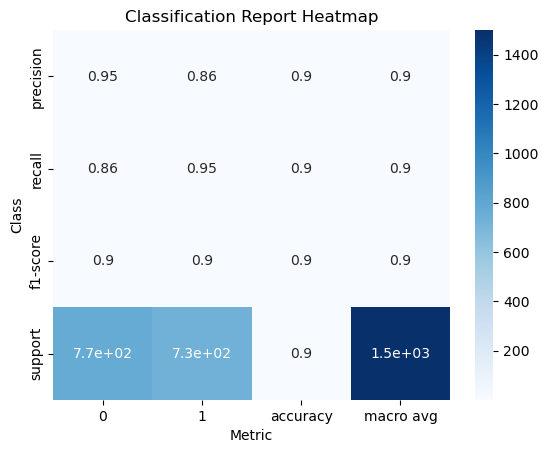


using genism
Accuracy: 0.834
F1 Score: 0.8324774808918927


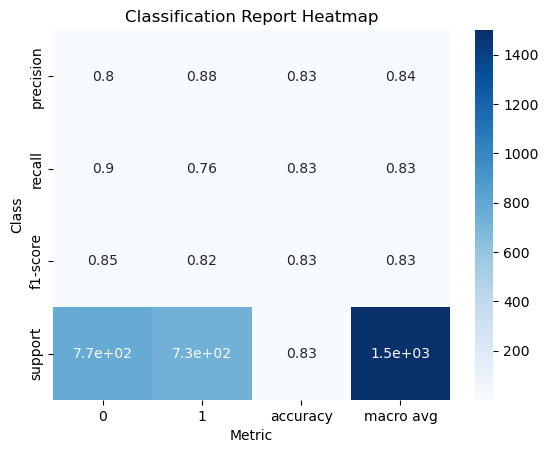


_________________________________

Dataset2 - 

using sklearn
Accuracy: 0.6996805111821086
F1 Score: 0.6963047068538398


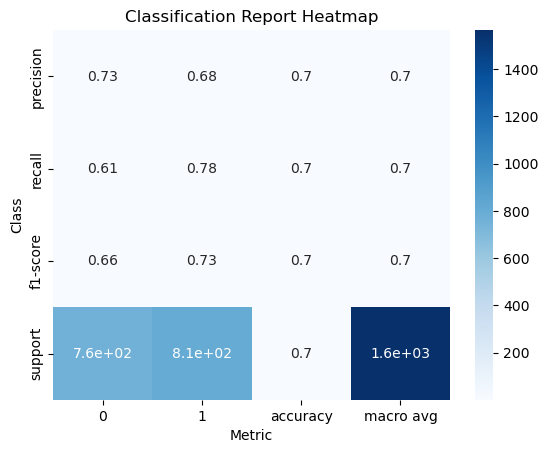


using genism
Accuracy: 0.708626198083067
F1 Score: 0.7081226993865031


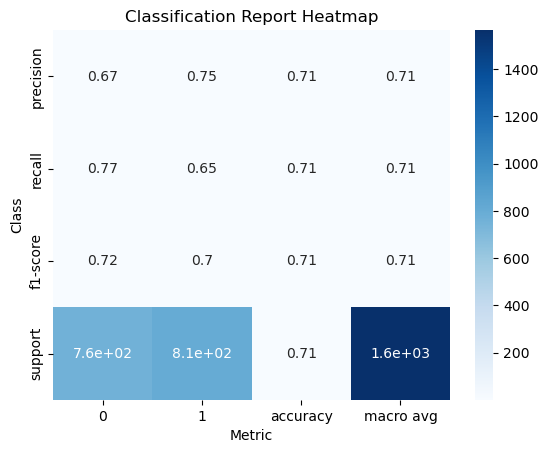


_________________________________

Dataset3 - 

using sklearn
Accuracy: 0.7354651162790697
F1 Score: 0.7316531653165317


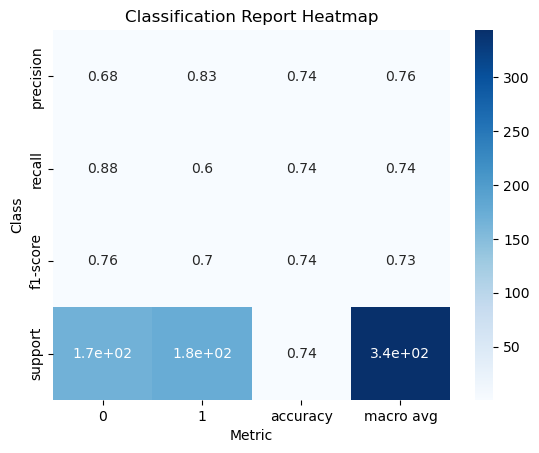


using genism
Accuracy: 0.7587209302325582
F1 Score: 0.754891103728313


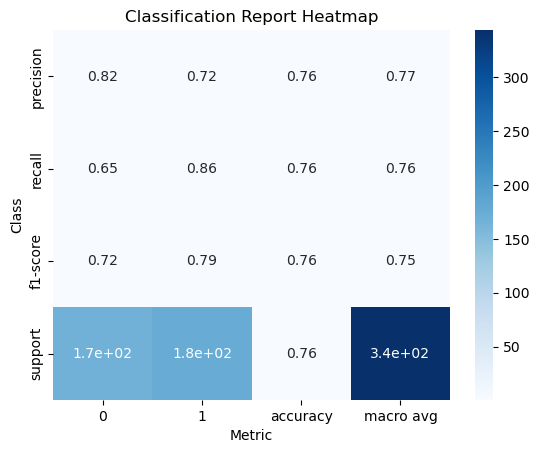

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.classify import NaiveBayesClassifier

import seaborn as sns
import matplotlib.pyplot as plt


def plot_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True,zero_division=1)
    report_df = pd.DataFrame(report).transpose()
    heatmap = sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Blues')
    heatmap.set(title='Classification Report Heatmap')
    plt.xlabel('Metric')
    plt.ylabel('Class')
    plt.show()


def NB_sklearn(df,clf_alpha, tfidf_ngram_range, tfidf_use_idf):
    data = df
    # Text preprocessing
    stop_words = set(stopwords.words('english'))

    # CountVectorizer hyperparameters
    max_df = 0.95
    min_df = 2

    # MultinomialNB hyperparameters
    alpha = 0.5

    vectorizer = TfidfVectorizer(stop_words=stop_words, max_df=max_df, min_df=min_df, ngram_range=tfidf_ngram_range, use_idf=tfidf_use_idf)
    X = vectorizer.fit_transform(data['tweet'])
    y = data['marker']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

    # Train the model
    nb_classifier = MultinomialNB(alpha=clf_alpha)
    nb_classifier.fit(X_train, y_train)

    # Test the model
    y_pred = nb_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Compute the F1 score of the model
    f1score = f1_score(y_test, y_pred, average='macro')
    print("F1 Score:", f1score)
    #print("\nMultinomialNB hyperparameters:\n", nb_classifier.get_params(), "\n")

    
    plot_classification_report(y_test, y_pred)
    #print(classification_report(y_test, y_pred, zero_division=1))


import gensim
from gensim.utils import simple_preprocess
from gensim import corpora
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report
from nltk.corpus import stopwords

# Load dataset

def NB_genism(df,clf_alpha, tfidf_ngram_range, tfidf_use_idf):
    X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['marker'], test_size=0.3, random_state=50)

    # Define the pipeline
    clf = Pipeline([
        ('tfidf', TfidfVectorizer(use_idf=tfidf_use_idf, ngram_range=tfidf_ngram_range)),
        ('clf', MultinomialNB(alpha=clf_alpha))
    ])

    # Train the model
    clf.fit(X_train, y_train)

    # Test the model
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Compute the F1 score of the model
    f1score = f1_score(y_test, y_pred, average='macro')
    print("F1 Score:", f1score)
    plot_classification_report(y_test, y_pred)
    #print("\nMultinomialNB hyperparameters:\n", clf.get_params())
    
    # Print classification report
    #print(classification_report(y_test, y_pred))


print("___________Naive Bayes___________")
print("Dataset1 - ")
print("\nusing sklearn")
NB_sklearn(df1,0.1, (1,2), False)
print("\nusing genism")
NB_genism(df1,0.1, (1,2), False)
print("\n_________________________________")
print("\nDataset2 - ")
print("\nusing sklearn")
NB_sklearn(df2,1, (1,2), False)
print("\nusing genism")
NB_genism(df2,1, (1,2), False)
print("\n_________________________________")
print("\nDataset3 - ")
print("\nusing sklearn")
NB_sklearn(df3,0.5, (1,2), False)
print("\nusing genism")
NB_genism(df3,0.5, (1,2), False)


___________KNN___________

Dataset1 - 

using sklearn
Accuracy: 0.5446666666666666
F1 Score: 0.415564968125615


C:\Users\Rizwana\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


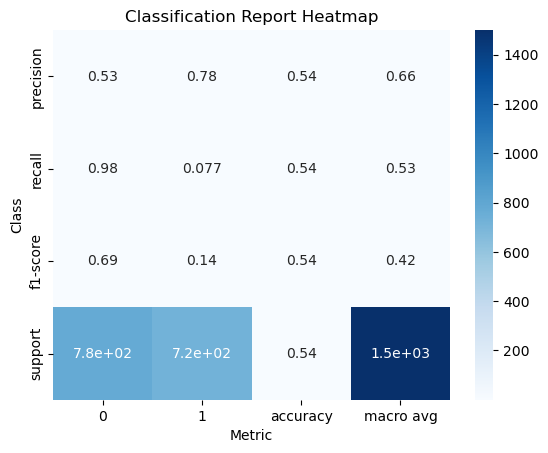


Dataset2 - 

using sklearn
Accuracy: 0.610223642172524
F1 Score: 0.605842279108175


C:\Users\Rizwana\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


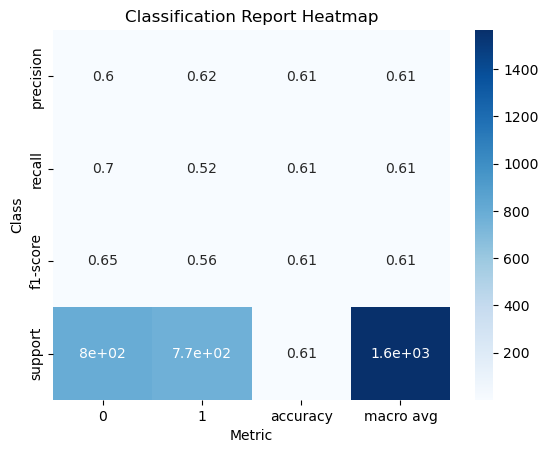

C:\Users\Rizwana\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)



Dataset3 - 

using sklearn
Accuracy: 0.6133720930232558
F1 Score: 0.5454211253191849


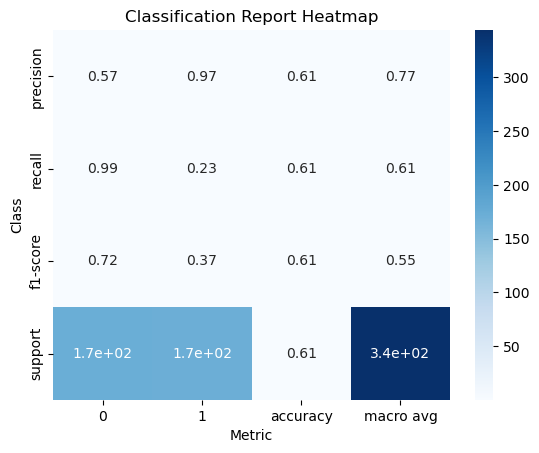

In [59]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

# Load the dataset

def knn_sklearn(df):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['marker'], test_size=0.3, random_state=42)

    # Create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Vectorize the training data
    X_train_vectorized = vectorizer.fit_transform(X_train)

    # Create a KNN classifier
    knn = KNeighborsClassifier(n_neighbors=5)

    # Train the classifier
    knn.fit(X_train_vectorized, y_train)

    # Vectorize the testing data
    X_test_vectorized = vectorizer.transform(X_test)

    # Make predictions on the test data
    y_pred = knn.predict(X_test_vectorized)

    # Evaluate the performance of the model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Print the evaluation metrics
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    plot_classification_report(y_test, y_pred)
    #print(classification_report(y_test, y_pred, zero_division=1))

print("___________KNN___________")
print("\nDataset1 - ")
print("\nusing sklearn")
knn_sklearn(df1)

print("\nDataset2 - ")
print("\nusing sklearn")
knn_sklearn(df2)

print("\nDataset3 - ")
print("\nusing sklearn")
knn_sklearn(df3)



___________KNN___________
Dataset1 - 

using scipy


C:\Users\Rizwana\AppData\Local\Temp\ipykernel_42660\1858413209.py:15: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return mode(y_train[indices])[0][0]


Accuracy: 0.644
F1 Score: 0.6270255168560253


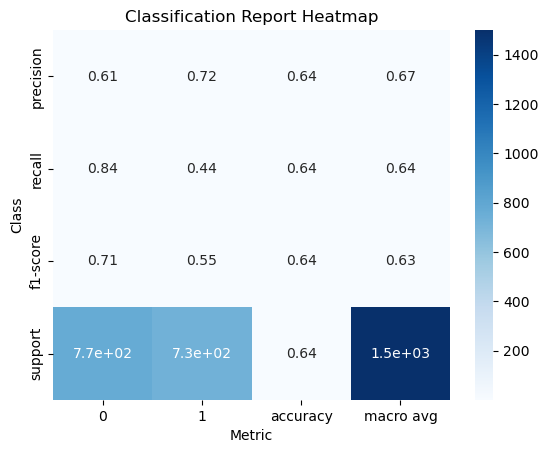

Dataset2 - 

using scipy


C:\Users\Rizwana\AppData\Local\Temp\ipykernel_42660\1858413209.py:15: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return mode(y_train[indices])[0][0]


Accuracy: 0.6242811501597444
F1 Score: 0.6241520937892095


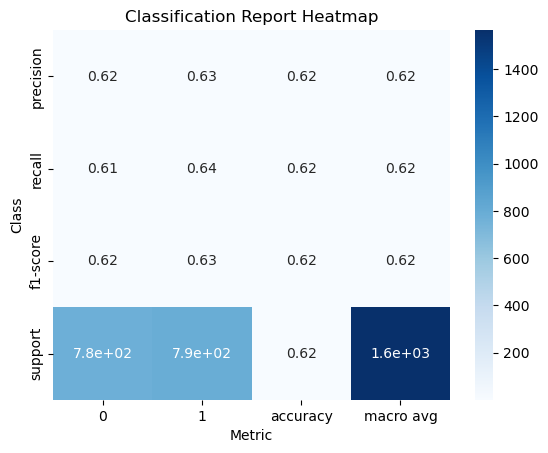

Dataset3 - 

using scipy


C:\Users\Rizwana\AppData\Local\Temp\ipykernel_42660\1858413209.py:15: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return mode(y_train[indices])[0][0]


Accuracy: 0.6337209302325582
F1 Score: 0.6301075268817204


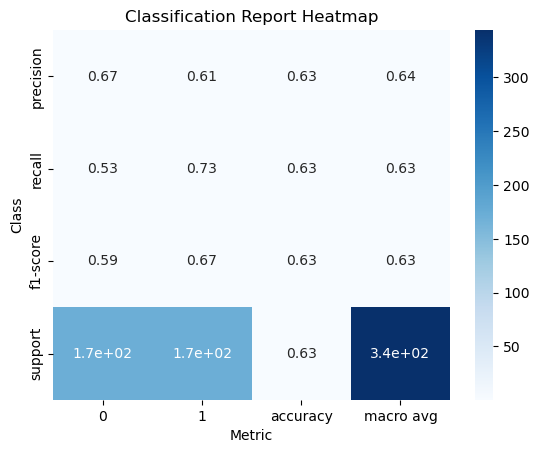

In [60]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import mode


# Define the function to compute distances
def distance(X_train, X_test):
    return cdist(X_train, X_test)

# Define the KNN algorithm
def knn(X_train, y_train, X_test, k):
    distances = distance(X_train, X_test)
    indices = np.argsort(distances, axis=0)[:k]
    return mode(y_train[indices])[0][0]

# Define the function to split the data into training and testing sets
def train_test_split_custom(X, y, split_ratio, random_state=42):
    idx = np.arange(X.shape[0])
    if random_state:
        np.random.seed(random_state)
    np.random.shuffle(idx)
    n_train = int(split_ratio * X.shape[0])
    X_train = X[idx[:n_train]]
    y_train = y[idx[:n_train]]
    X_test = X[idx[n_train:]]
    y_test = y[idx[n_train:]]
    return X_train, y_train, X_test, y_test

def KNN_scipy(df):
    # Load the dataset
    # Define the feature and target variables
    X = df['tweet'].values
    y = df['marker'].values

    random_state = 42
    # Split the dataset into training and testing sets
    X_train, y_train, X_test, y_test = train_test_split_custom(X, y, 0.7, random_state)

    # Convert the text data to numerical data using Bag-of-Words representation
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer()
    X_train_bow = vectorizer.fit_transform(X_train)
    X_test_bow = vectorizer.transform(X_test)

    # Use the KNN algorithm to make predictions
    k = 5
    y_pred = []
    for i in range(X_test_bow.shape[0]):
        y_pred.append(knn(X_train_bow.toarray(), y_train, X_test_bow[i].toarray(), k))

    # Compute the accuracy of the model
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Compute the F1 score of the model
    f1score = f1_score(y_test, y_pred, average='macro')
    print("F1 Score:", f1score)
    plot_classification_report(y_test, y_pred)
    #print(classification_report(y_test, y_pred, zero_division=1))


print("___________KNN___________")
print("Dataset1 - ")
print("\nusing scipy")
KNN_scipy(df1)

print("Dataset2 - ")
print("\nusing scipy")
KNN_scipy(df2)

print("Dataset3 - ")
print("\nusing scipy")
KNN_scipy(df3)
